# Data Preperation

The spatial transcriptomics data used in this study is publicly available, with detailed experimental methods discussed in a previous publication. In this Chapter, we discuss how the data was prepared for their analysis. The data is published on the Gene Expression Omnibus (GEO) database and can be accessed using the GEO accession: GSE188805. Once the data is retrieved, we introduce a basic pre-processing workflow, including steps to filter unwanted spots and genes, along with the application of a data normalization technique.

In [1]:
import anndata as ad
import numpy as np
import pandas as pd

In [2]:
# Custom Plotting functions
import plot_st
import importlib
importlib.reload(plot_st)

<module 'plot_st' from '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/plot_st.py'>

In [3]:
root_dir = '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/'

In [4]:
# Read the data

adata_dir = root_dir + 'Raw_Initial_Data/'
adata_M24 = ad.read_h5ad(adata_dir + 'raw_M24.h5ad')
adata_F31 = ad.read_h5ad(adata_dir + 'raw_F31.h5ad')
adata_M63 = ad.read_h5ad(adata_dir + 'raw_M63.h5ad')
adata_F62 = ad.read_h5ad(adata_dir + 'raw_F62.h5ad')

In [5]:
# Guestimate the line which separate the upper airway and lung tissues.
def line(x):
  return -0.6 * x + 6900

In [6]:
distance = adata_F31.obsm['spatial'][:,1] - line(adata_F31.obsm['spatial'][:,0])
adata_F31 = adata_F31[distance < 0]
adata_F31.write_h5ad(adata_dir + 'no_airway_F31.h5ad')

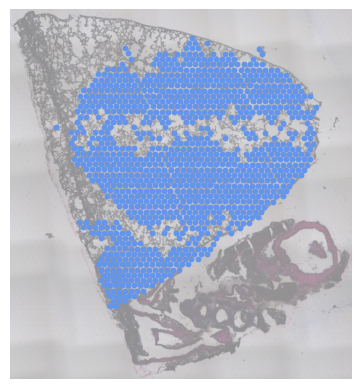

In [7]:
plot_st.spatial(adata_F31)

## Macrophage Identification

The identification of spots containing macrophage cells is identified based on
the level expression of macrophage biomarkers such as *Cd14* , *Cd68*, or
*Adgre1*. We will build a function to annotate macrophage spots and plot them as green spot, where non-macrophage spots are in cornflowerblue.

We will also save the macrophage spots to a new data containers.

In [8]:
def create_macrophage_adata (adata):
    macrophage_markers = ['Cd14', 'Cd68', 'Adgre1']
    mask1 = np.isin(adata.var_names, macrophage_markers)
    total_counts = np.array(adata.X[:, mask1].sum(axis=1))
    mask = (total_counts > 0)

    macrophage_adata = ad.AnnData(adata[mask].X)
    macrophage_adata.obs_names = adata[mask].obs_names
    macrophage_adata.var_names = adata[mask].var_names
    macrophage_adata.obsm['spatial'] = adata[mask].obsm['spatial']
    macrophage_adata.uns['extent'] = adata.uns['extent']
    macrophage_adata.uns['lung_image'] = adata.uns['lung_image']

    return macrophage_adata

In [ ]:
!mkdir results 
!mkdir results/macrophage_data

In [11]:
macrophage_dir = 'results/macrophage_data/'

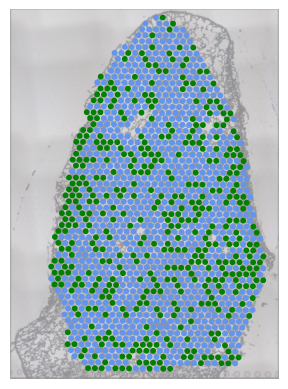

In [12]:
macrophage_M24 = create_macrophage_adata(adata_M24)
macrophage_M24.write_h5ad(root_dir + macrophage_dir + 'macrophage_M24.h5ad')
plot_st.spatial_macrophage(adata_M24)

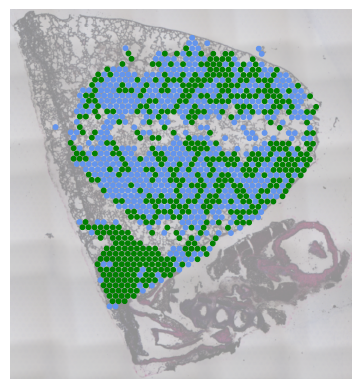

In [13]:
macrophage_F31 = create_macrophage_adata(adata_F31)
macrophage_F31.write_h5ad(root_dir + macrophage_dir + 'macrophage_F31.h5ad')
plot_st.spatial_macrophage(adata_F31)

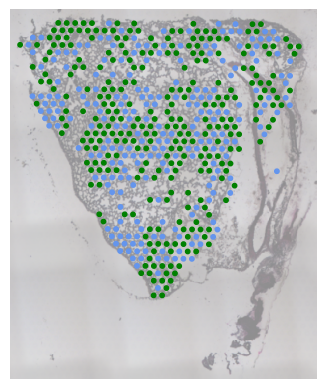

In [14]:
macrophage_M63 = create_macrophage_adata(adata_M63)
macrophage_M63.write_h5ad(root_dir + macrophage_dir + 'macrophage_M63.h5ad')
plot_st.spatial_macrophage(adata_M63)

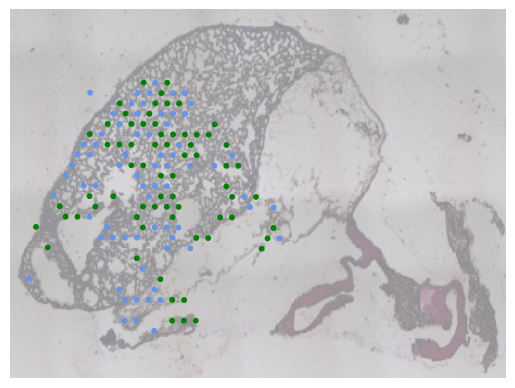

In [15]:
macrophage_F62 = create_macrophage_adata(adata_F62)
macrophage_F62.write_h5ad(root_dir + macrophage_dir + 'macrophage_F62.h5ad')
plot_st.spatial_macrophage(adata_F62)

In [16]:
macrophage_M24 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_M24.h5ad')
macrophage_F31 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_F31.h5ad')
macrophage_M63 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_M63.h5ad')
macrophage_F62 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_F62.h5ad')

In [17]:
def map_macrophage(adata):
  macrophage_markers = ['Cd14', 'Cd68', 'Adgre1']
  mask1 = np.isin(adata.var_names, macrophage_markers)
  total_counts = np.array(adata.X[:, mask1].sum(axis=1))
  mask = (total_counts > 0)

  macro_ = []
  for c in mask:
      if c:
          macro_.append('Macrophage Spot')
      else:
          macro_.append('Non Macrophage Spot')
  return pd.Series(macro_)

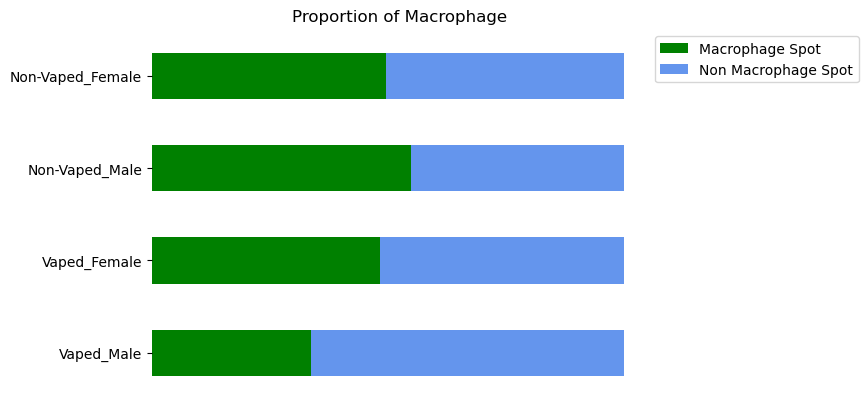

In [18]:
mac_24 = map_macrophage(adata_M24)
dict1 = dict(mac_24.value_counts(normalize=True) * 100)

mac_31 = map_macrophage(adata_F31)
dict2 = dict(mac_31.value_counts(normalize=True) * 100)

mac_63 = map_macrophage(adata_M63)
dict3 = dict(mac_63.value_counts(normalize=True) * 100)

mac_62 = map_macrophage(adata_F62)
dict4 = dict(mac_62.value_counts(normalize=True) * 100)

color_code_M = dict(zip(['Macrophage Spot', 'Non Macrophage Spot'], ['green', 'cornflowerblue']))
df = pd.DataFrame({'Vaped_Male' : dict1,
                   'Vaped_Female' : dict2,
                   'Non-Vaped_Male' : dict3,
                   'Non-Vaped_Female' : dict4}).T
df = df.fillna(0)
df = df[['Macrophage Spot', 'Non Macrophage Spot']]
ax = df.plot.barh(
    stacked = True,
    title = 'Proportion of Macrophage',
    color=color_code_M)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_visible(False)

## Quality Control

For Quality Control (QC), we will utilize [**Scanpy**](https://scanpy.readthedocs.io/en/stable/) package.

We will plot some basic QC plots to understand the distribution of total counts, gene counts, and percentage of mitochondrial.

* Spots that contained a total number of gene counts outside the 95th percentile for all spots were removed from the analysis.
* Spots that were identified to contain more than 20 percent of mitochondrial genes were removed from analysis to remove poor-quality spots.


In [19]:
import scanpy as sc

The ```preprocessing``` function calculates the total expression, gene counts, and percentage in mitochondrial in each spot. Those metrics are saved in the data container. The function also plots some of the basic QC plots such as the distribution of level of expressions and number of gene counts.

Spots that contained a total number of gene counts outside the 95th percentile for all spots were removed from the analysis. Spots that were identified to contain more than 20 percent of mitochondrial genes were removed from analysis to remove poor-quality spots.

Following filtering, there were a total of 261 spots in the Non-Vaped Male, 65 spots in the Non-Vaped Female, 436 in the Vaped Male, and 487 spots in the Vaped Female. All samples were then combined into one data set for gene filtering and normalization.

In [20]:
def preprocessing (adata):
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

    plot_st.total_plot(adata)
    plot_st.gene_count_plot(adata)
    plot_st.QC_plot(adata)
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

    upper_lim_counts = np.quantile(adata.obs.total_counts.values, 0.95) # 95% percentile to be more objective
    adata = adata[adata.obs['total_counts'] < upper_lim_counts]

    adata = adata[adata.obs['pct_counts_mt'] < 20]

    return adata

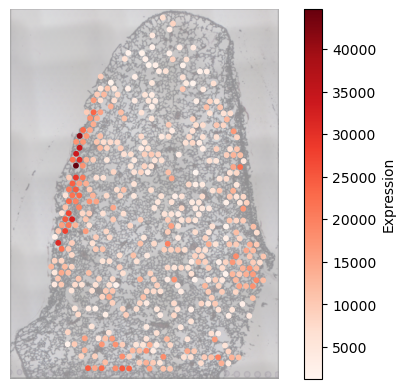

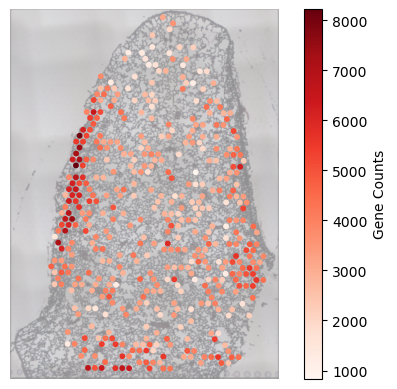

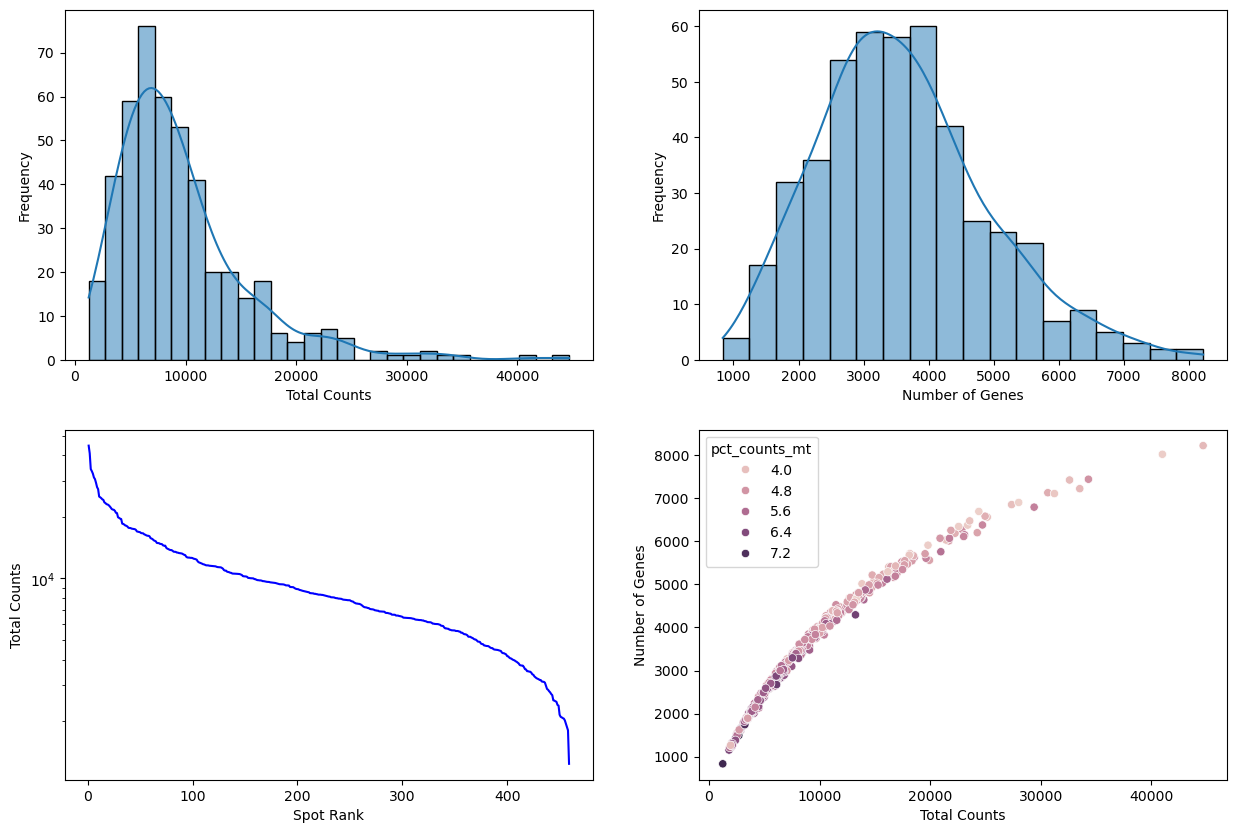

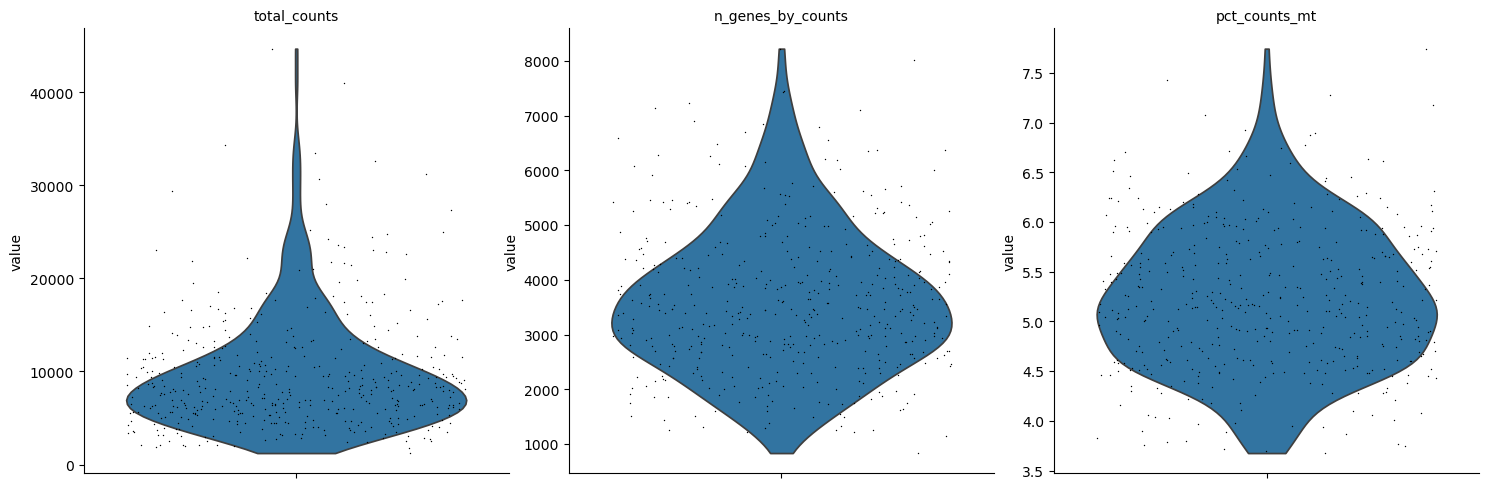

In [21]:
macrophage_M24 = preprocessing(macrophage_M24)

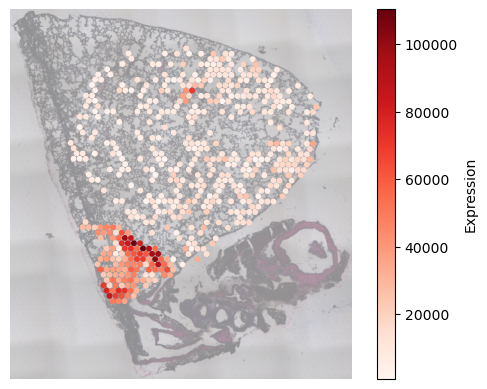

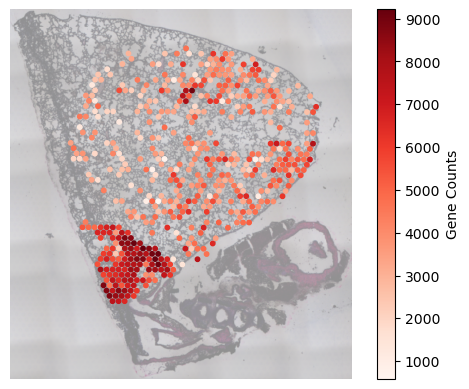

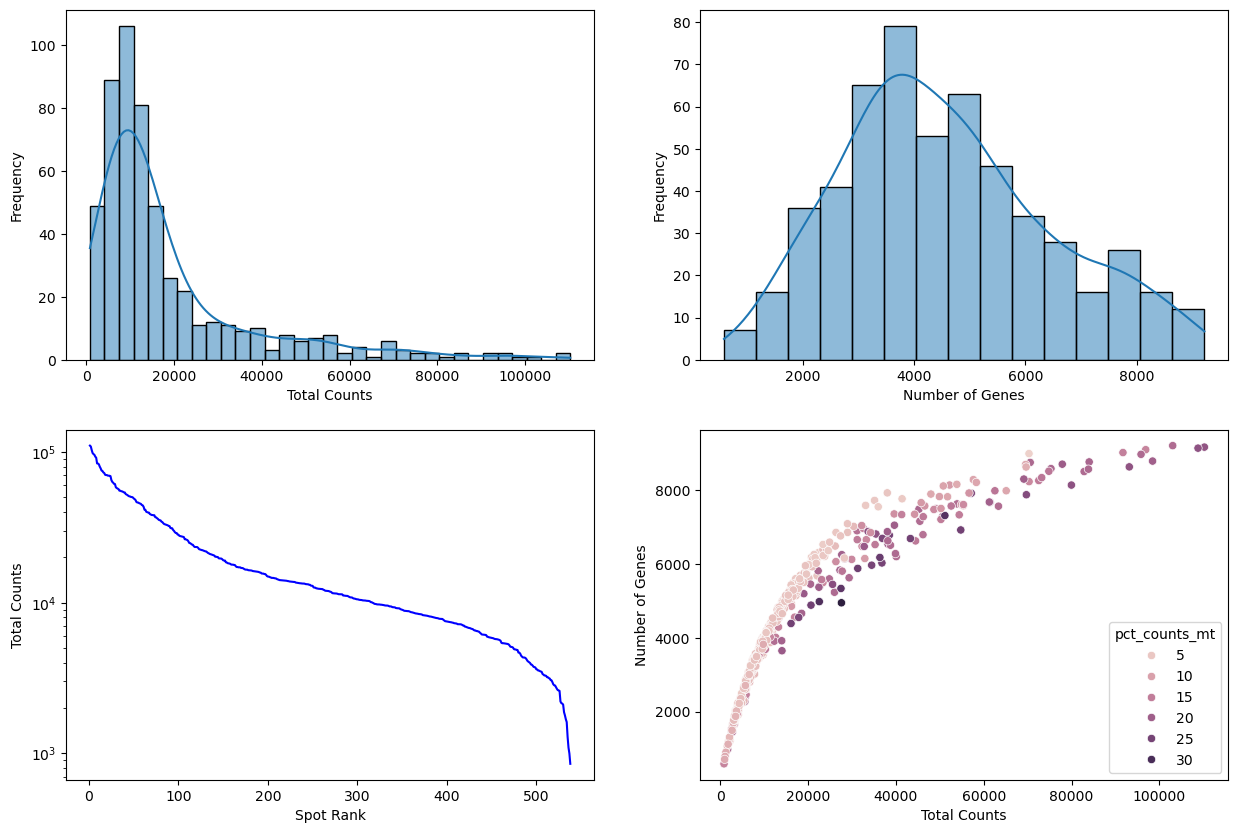

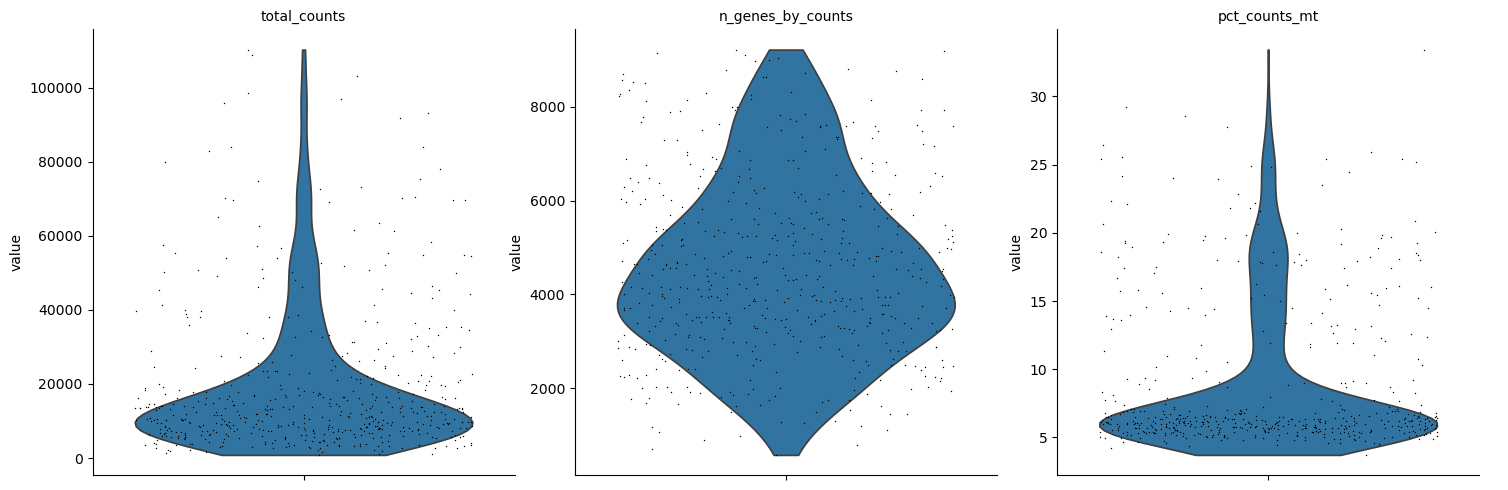

In [22]:
macrophage_F31 = preprocessing(macrophage_F31)

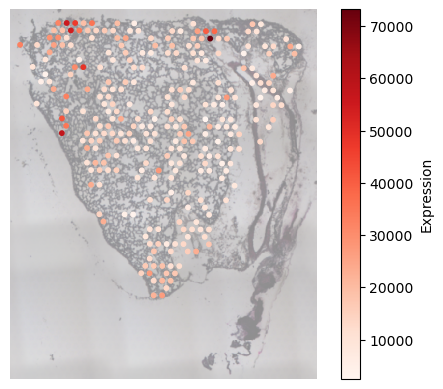

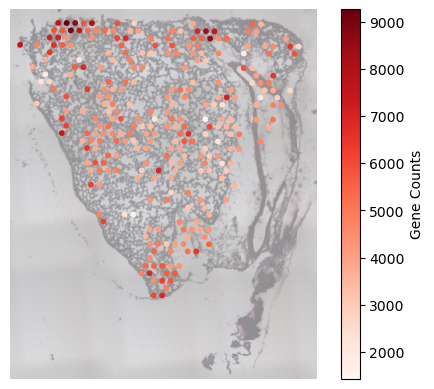

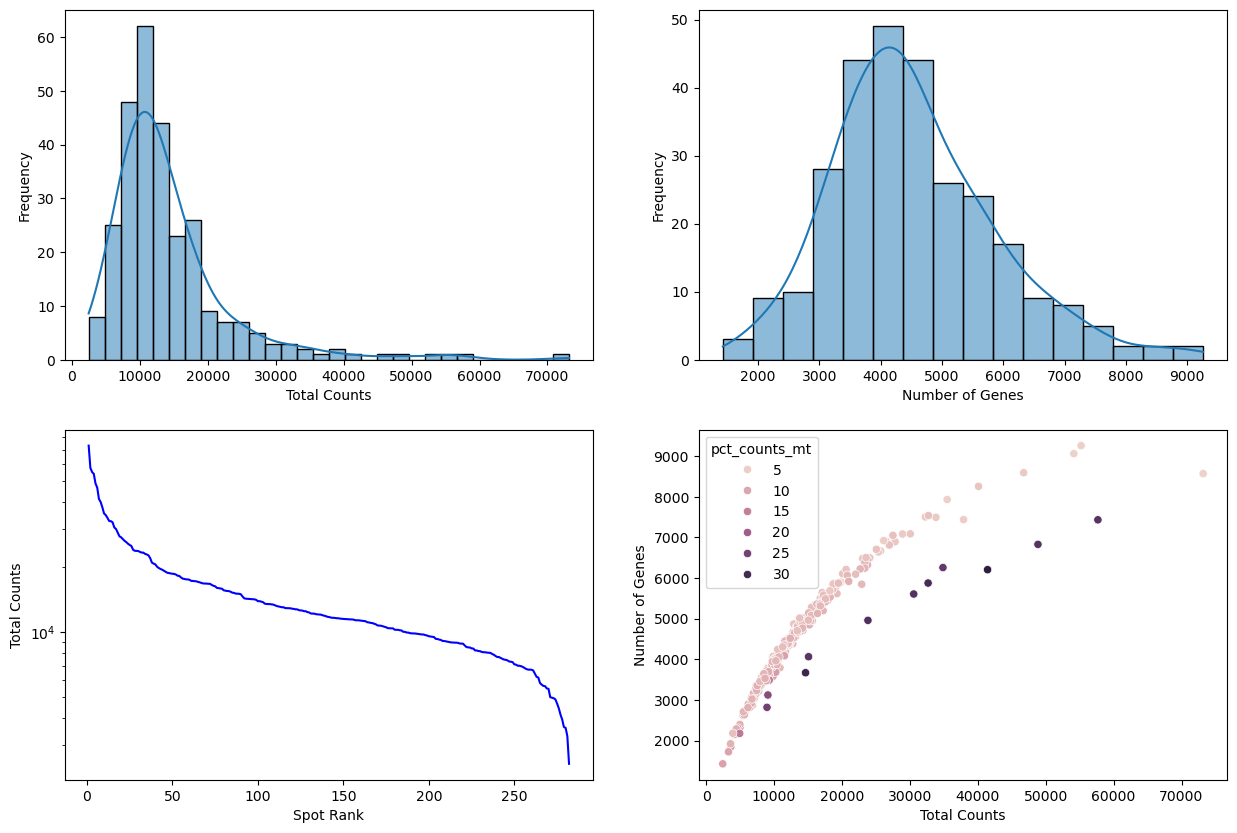

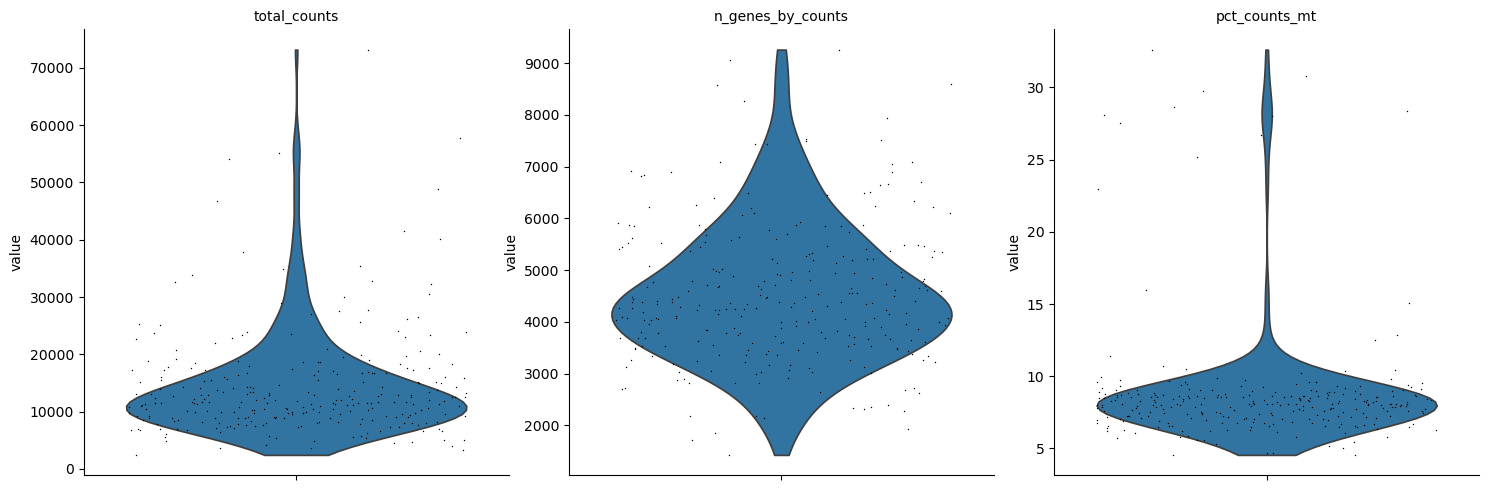

In [23]:
macrophage_M63 = preprocessing(macrophage_M63)

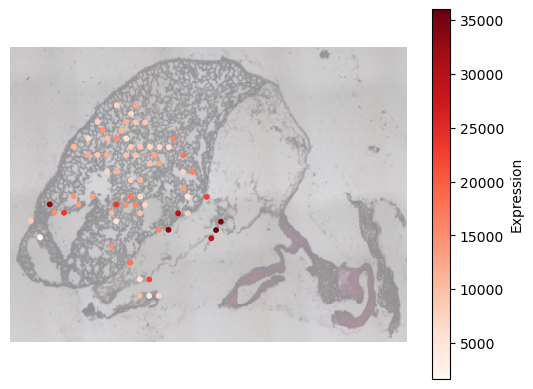

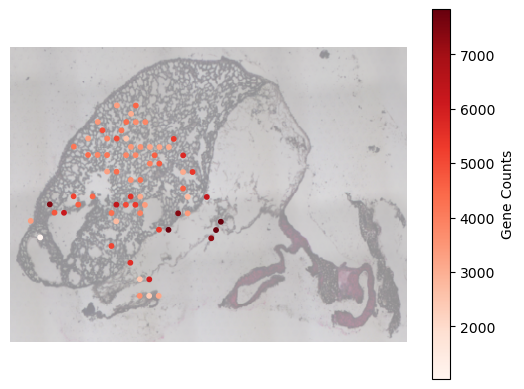

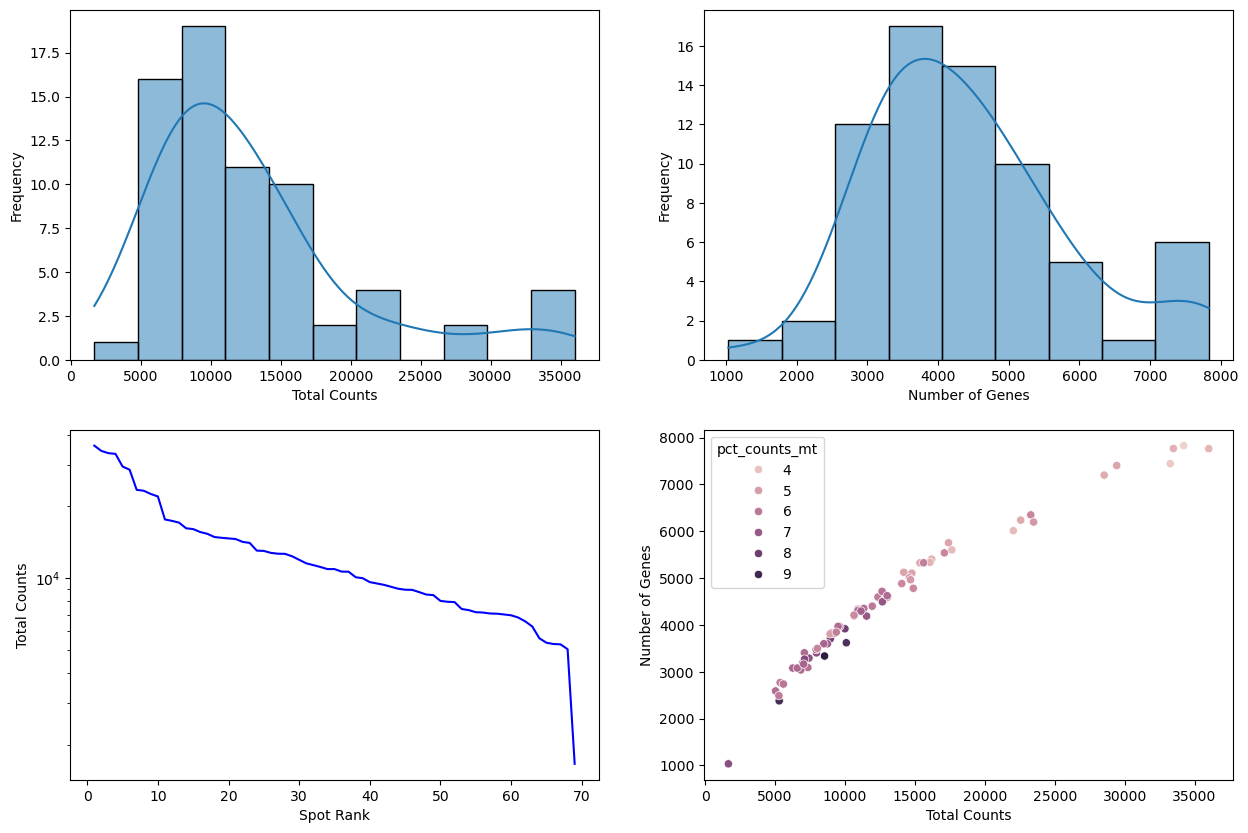

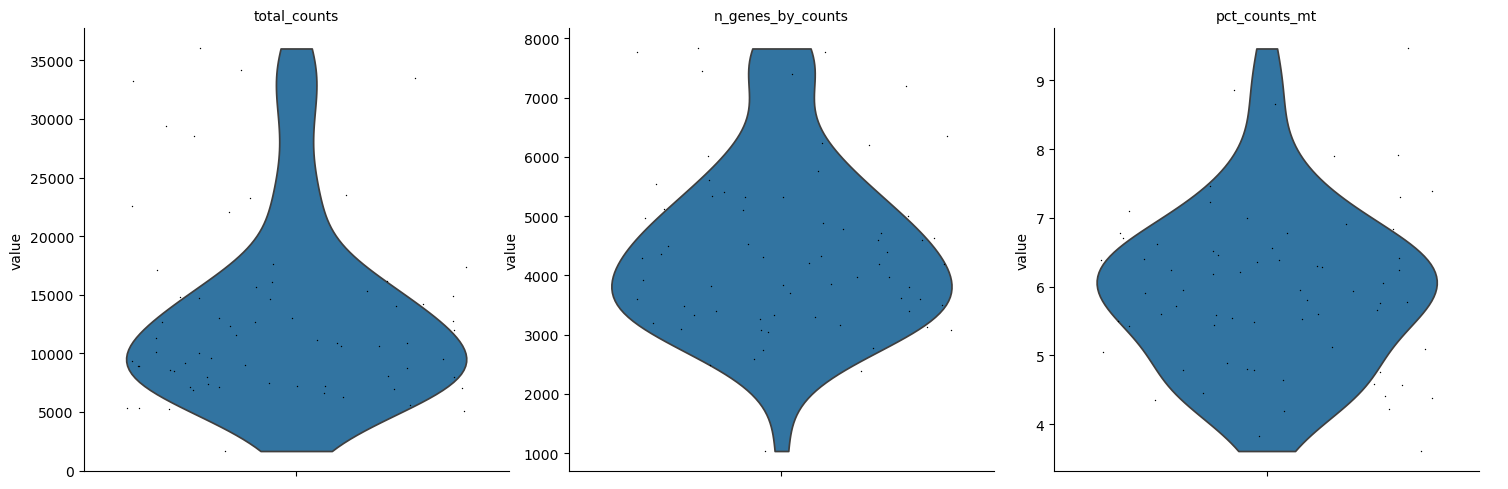

In [24]:
macrophage_F62 = preprocessing(macrophage_F62)

In [25]:
macrophage_M24.obs['lung'] = 'Z_Per'
macrophage_M24.obs['sex'] = 'male'
macrophage_M24.obs['sample'] = '0_Per_1_M24'

macrophage_F31.obs['lung'] = 'Z_Per'
macrophage_F31.obs['sex'] = 'female'
macrophage_F31.obs['sample'] = '0_Per_2_F31'

macrophage_M63.obs['lung'] = 'CTL'
macrophage_M63.obs['sex'] = 'male'
macrophage_M63.obs['sample'] = 'CTL_1_M63'

macrophage_F62.obs['lung'] = 'CTL'
macrophage_F62.obs['sex'] = 'female'
macrophage_F62.obs['sample'] = 'CTL_2_F62'

adata_all = sc.concat([macrophage_M24, macrophage_F31,
                       macrophage_M63, macrophage_F62])
adata_all

/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_92377/1024109031.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_M24.obs['lung'] = 'Z_Per'
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_92377/1024109031.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_F31.obs['lung'] = 'Z_Per'
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_92377/1024109031.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_M63.obs['lung'] = 'CTL'
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_92377/1024109031.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_F62.obs['lung'] = 'CTL'


AnnData object with n_obs × n_vars = 1249 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'lung', 'sex', 'sample'
    obsm: 'spatial'

Gene filtering was conducted to remove low expression level genes, which are not informative of the cellular heterogeneity. Any gene identified in 3 or fewer spots across samples was removed from the analysis. We also filter genes for individual sample for analysis that will be performed on each sample.

In [59]:
sc.pp.filter_genes(adata_all, min_cells = 4)
adata_all

AnnData object with n_obs × n_vars = 1249 × 16448
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'lung', 'sex', 'sample'
    var: 'n_cells'
    obsm: 'spatial'

In [26]:
sc.pp.filter_genes(macrophage_M24, min_cells = 4)
sc.pp.filter_genes(macrophage_F31, min_cells = 4)
sc.pp.filter_genes(macrophage_M63, min_cells = 4)
sc.pp.filter_genes(macrophage_F62, min_cells = 4)

## Data Normalization

Normalizing the data to ten thousand reads per spot made the counts comparable among spots. Each read count is divided by the total read count in a spot, followed by multiplying by 1, 000. The normalization can be expressed in the following formula:

$$\textsf{Normalized Count} = \frac{\textsf{Number of gene counts} \times 10^4}{\textsf{Total number of gene counts in spot}}$$

In [27]:
def normalization (adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

    sc.pp.highly_variable_genes(adata, n_top_genes=3000, inplace=True,
                                layer = 'counts', flavor = 'seurat_v3')

In [61]:
normalization(adata_all)

In [28]:
normalization(macrophage_M24)
normalization(macrophage_F31)
normalization(macrophage_M63)
normalization(macrophage_F62)

In [62]:
# Add the lungs picture for easier plotting
adata_all.uns['extent_M24'] = [1800, 5220, 1900, 6600]
adata_all.uns['lung_image_M24'] = root_dir + 'lungs_images/M24.png'

adata_all.uns['extent_F31'] = [1000, 5900, 1100, 6400]
adata_all.uns['lung_image_F31'] = root_dir + 'lungs_images/F31.png'

adata_all.uns['extent_M63'] = [2250, 5400, 2700, 6500]
adata_all.uns['lung_image_M63'] = root_dir + 'lungs_images/M63.png'

adata_all.uns['extent_F62'] = [2670, 6300, 2900, 5600]
adata_all.uns['lung_image_F62'] = root_dir + 'lungs_images/F62.png'

In [4]:
adata_all.write_h5ad(root_dir + 'results/adata_all.h5ad')

In [29]:
macrophage_M24.write_h5ad(root_dir + 'results/macrophage_M24.h5ad')
macrophage_F31.write_h5ad(root_dir + 'results/macrophage_F31.h5ad')
macrophage_M63.write_h5ad(root_dir + 'results/macrophage_M63.h5ad')
macrophage_F62.write_h5ad(root_dir + 'results/macrophage_F62.h5ad')